In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader import VitalSignsDataset,vital_pre_train
from model.lstm.autoencoder_v3_lstm import *
from model.lstm.autoencoder_v3_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-01 13:41:51.662300: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=16, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [6]:
from torch.utils.data import DataLoader, TensorDataset

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
dataset_train = VitalSignsDataset(vital_signs_train)

labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

train_loader = DataLoader( dataset_train,batch_size=16,shuffle=True,collate_fn=vital_pre_train )
small_data_iter = iter(train_loader) 
inputs, lengths,idx,cat  = next(small_data_iter)   

original_indices = torch.arange(len(inputs))
small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=200, save_dir=stage1_dir, patience=50,kl_warmup_epochs=120)

[Epoch 9] KL weight: 0.0001, KL: 0.0394
[Epoch 19] KL weight: 0.0002, KL: 0.0765
[Epoch 29] KL weight: 0.0002, KL: 0.0860
[Epoch 39] KL weight: 0.0003, KL: 0.0802
[Epoch 49] KL weight: 0.0004, KL: 0.1354
[VAE Pretrain] Epoch 50/200 Avg ELBO: -188.6822 (Recon: -188.8176, KLw: 0.1354)
[Epoch 59] KL weight: 0.0005, KL: 0.2377
[Epoch 69] KL weight: 0.0006, KL: 0.2995
[Epoch 79] KL weight: 0.0007, KL: 0.3498
[Epoch 89] KL weight: 0.0007, KL: 0.3989
[Epoch 99] KL weight: 0.0008, KL: 0.4446
[VAE Pretrain] Epoch 100/200 Avg ELBO: -286.3177 (Recon: -286.7623, KLw: 0.4446)
[Epoch 109] KL weight: 0.0009, KL: 0.4871
[Epoch 119] KL weight: 0.0010, KL: 0.5319
[Epoch 129] KL weight: 0.0010, KL: 0.5434
[Epoch 139] KL weight: 0.0010, KL: 0.5466
[Epoch 149] KL weight: 0.0010, KL: 0.5498
[VAE Pretrain] Epoch 150/200 Avg ELBO: -329.5380 (Recon: -330.0878, KLw: 0.5498)
[Epoch 159] KL weight: 0.0010, KL: 0.5560
[Epoch 169] KL weight: 0.0010, KL: 0.5592
[Epoch 179] KL weight: 0.0010, KL: 0.5620
[Epoch 189] K

In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage1/best_ae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

In [ ]:
initialize_som_from_data(model, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [5]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=100,save_dir=stage2_dir,patience=50)

[SOM] Phase 1 Epoch 10/100 Avg Loss: 0.0693
[SOM] Phase 1 Epoch 20/100 Avg Loss: 0.0682
[SOM] Phase 1 Epoch 30/100 Avg Loss: 0.0675
[SOM] Phase 2 Epoch 40/100 Avg Loss: 0.0677
[SOM] Phase 2 Epoch 50/100 Avg Loss: 0.0672
[SOM] Phase 2 Epoch 60/100 Avg Loss: 0.0673
[SOM] Phase 3 Epoch 70/100 Avg Loss: 0.0640
[SOM] Phase 3 Epoch 80/100 Avg Loss: 0.0634
[SOM] Phase 3 Epoch 90/100 Avg Loss: 0.0638


In [4]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage2/best_som.pth'
model2 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

<All keys matched successfully>

In [8]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model2,train_loader, val_loader, train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 3126284
[Joint] Calculating  patient_start_offset_global (once before training)...


[Joint]  patient_start_offset_global calculated. Shape: torch.Size([2150])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


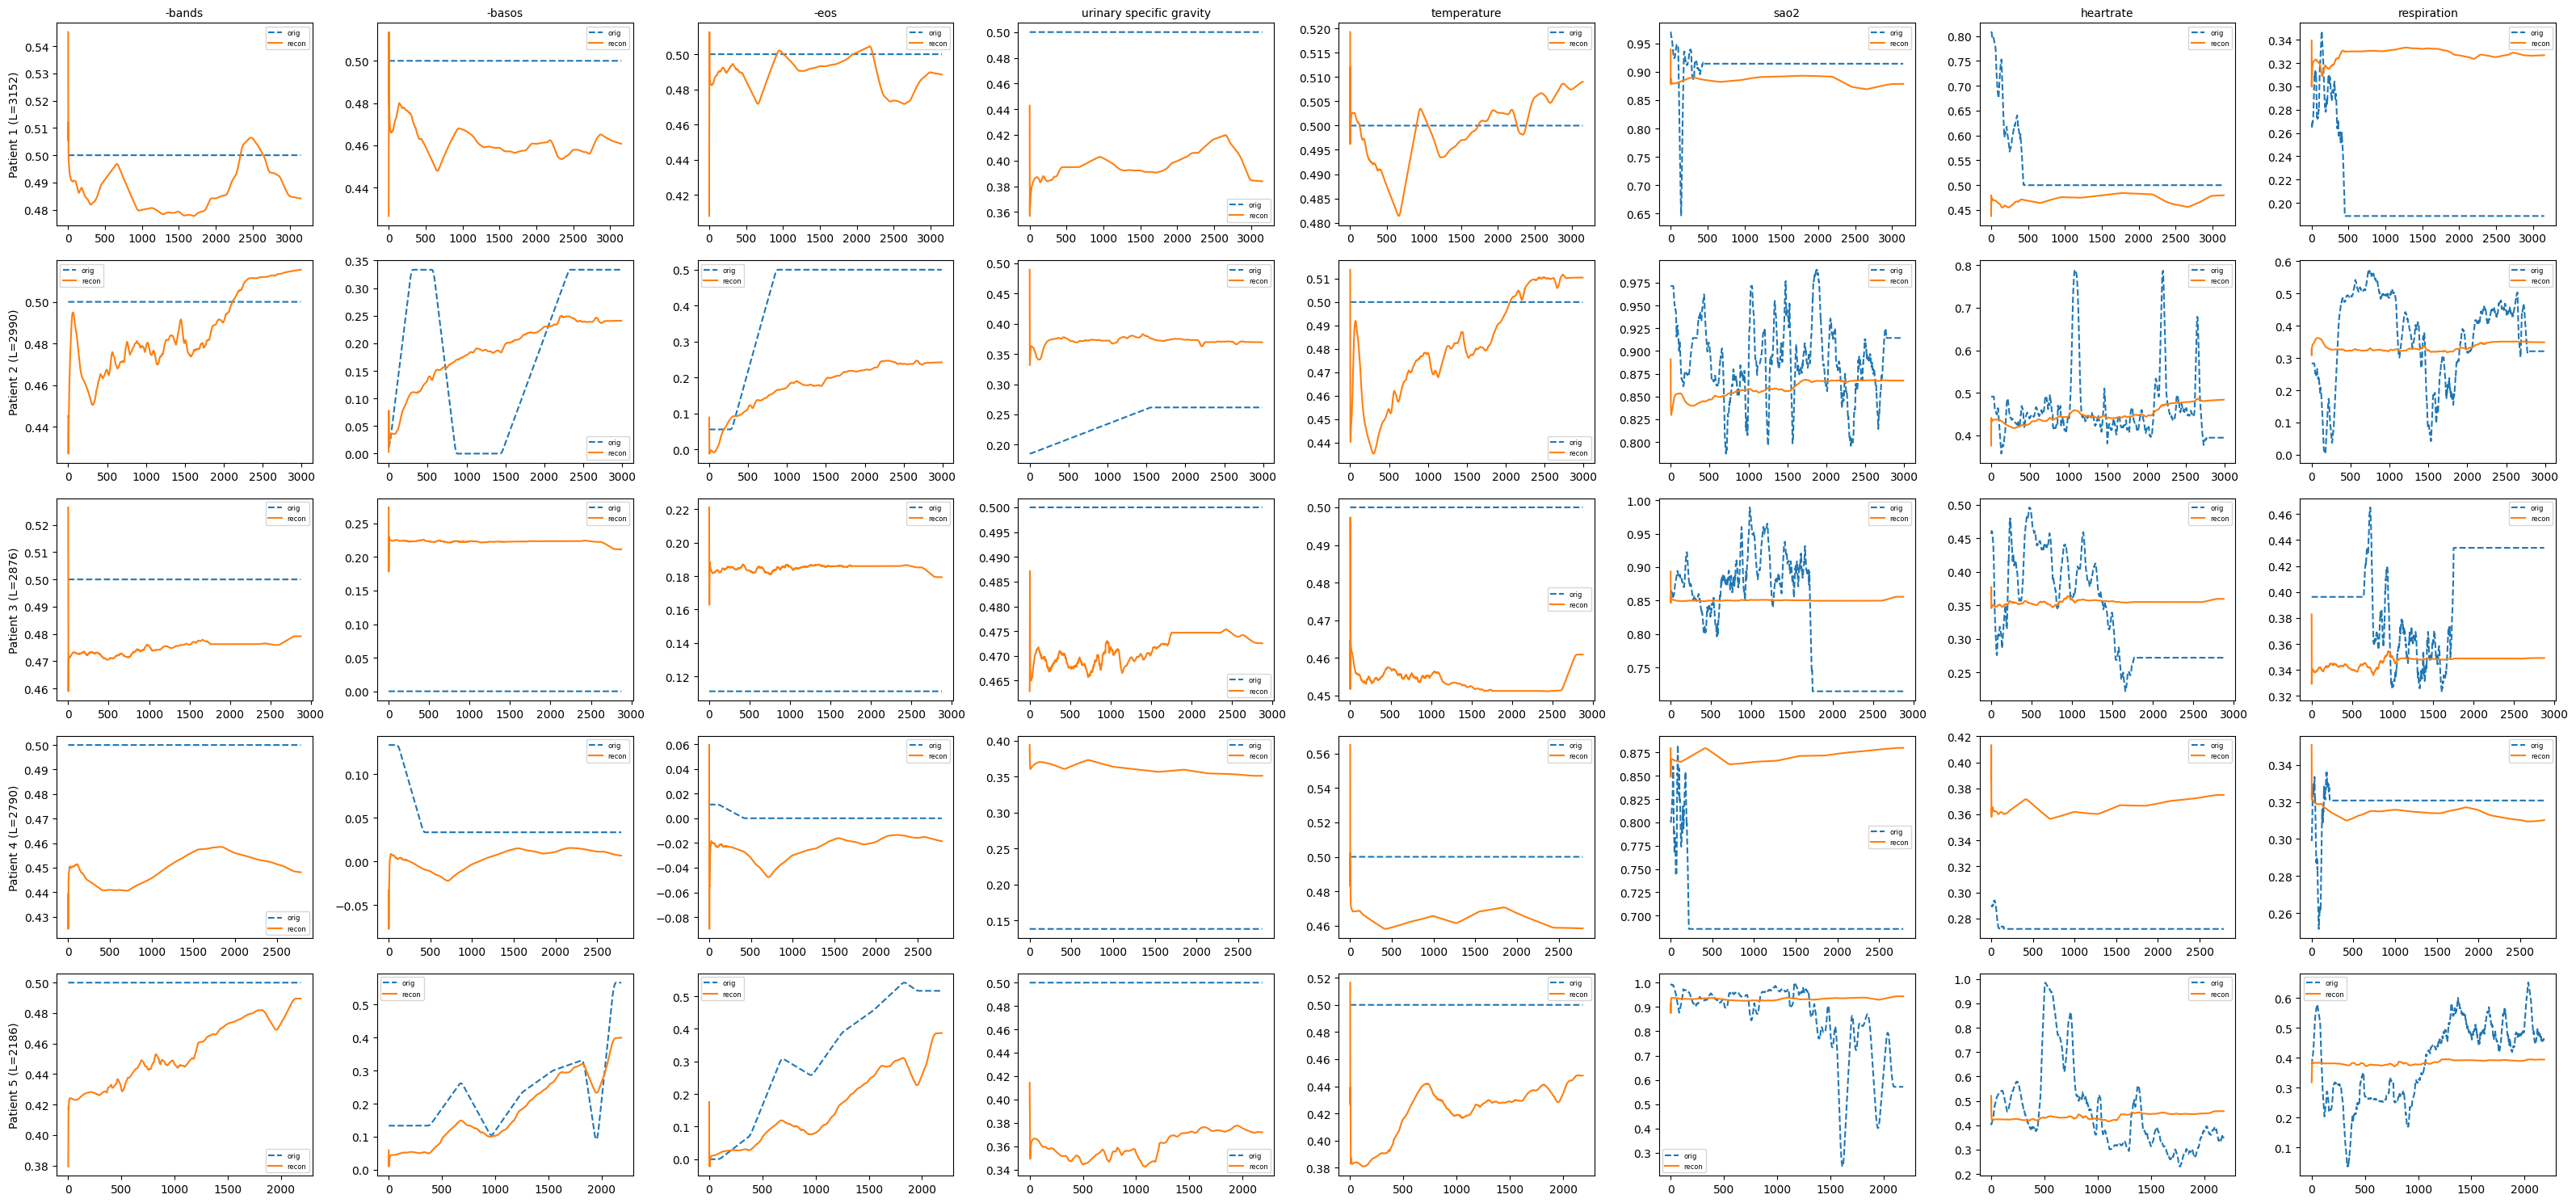

In [9]:
## 32
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]
selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 487226 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): -0.0001
  Std (overall): 0.0977
  Per-dim mean:
tensor([ 0.0416, -0.1025, -0.0420,  0.0846,  0.0779, -0.0504,  0.1432,  0.0581,
         0.1611,  0.0052,  0.0088, -0.0627,  0.0232,  0.0790, -0.0820, -0.0594,
        -0.1069, -0.1028, -0.0415,  0.1093,  0.0078,  0.0958,  0.0237,  0.0315,
        -0.1551, -0.1089,  0.0753,  0.2117, -0.1216,  0.0727, -0.1575,  0.0877,
        -0.0547,  0.0645, -0.0411,  0.0651,  0.0928,  0.0027,  0.1737,  0.0871,
         0.0724, -0.1037, -0.1437,  0.0999,  0.0408, -0.1829, -0.2057,  0.1533,
         0.0426, -0.2188,  0.0703, -0.0828,  0.0004, -0.0368, -0.1670, -0.0313,
        -0.2084, -0.0109, -0.1125, -0.0734, -0.0143, -0.0763, -0.1134,  0.0621,
        -0.2326, -0.0728, -0.0095, -0.0614,  0.0128, -0.0799, -0.1202,  0.0800,
         0.1125,  0.0603, -0.0740,  0.0050,  0.0082,  0.0335,  0.0262, -0.0698,
         0.1092, -0.1242,  0.0264, -0.0

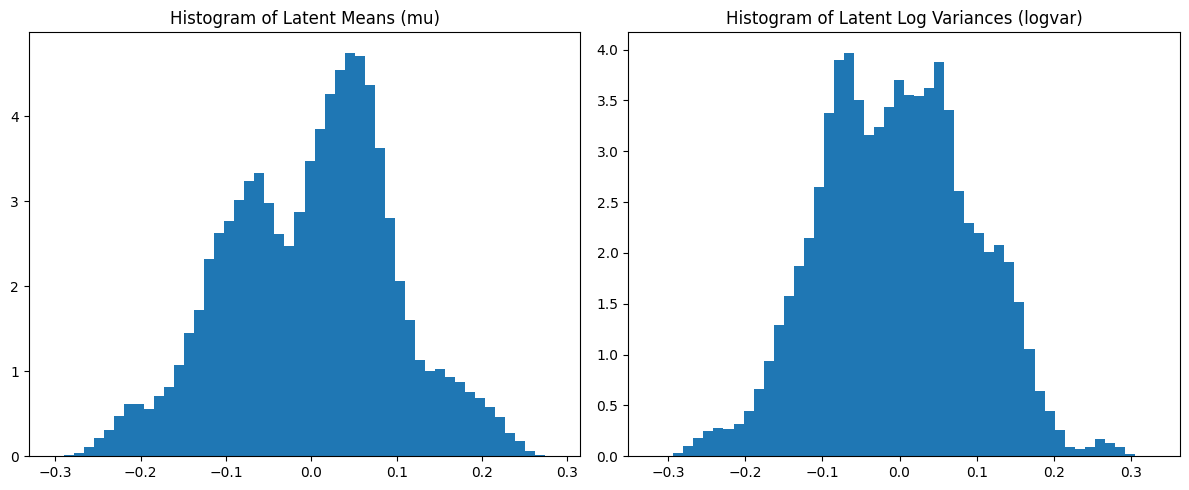

In [10]:
analyze_latent_stats(model, train_loader, device, num_batches_to_analyze=20)

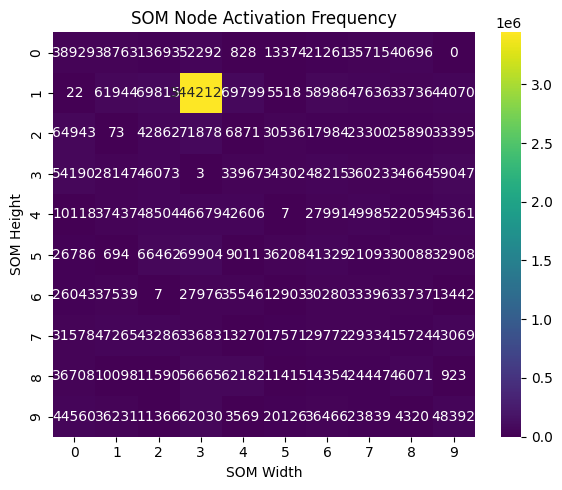

In [11]:
activation_map = compute_som_activation_heatmap(model3, train_loader, device)
plot_som_activation_heatmap(activation_map)